<a href="https://colab.research.google.com/github/Yufanzh/02_study/blob/master/ML_for_credit_card_fraud_detection_baseline_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Baseline fraud detection system
A supervised learning method
The design of a fraud detection system will consist of three main steps:
1. **Define training and testing set**
2. **Training a prediction model**
3. **Assessing the performance of the prediction model**

In [5]:
# Initialization: Load shoared functions and simulated data

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   276k      0 --:--:-- --:--:-- --:--:--  275k
Cloning into 'simulated-data-transformed'...
remote: Enumerating objects: 189, done.
remote: Total 189 (delta 0), reused 0 (delta 0), pack-reused 189
Receiving objects: 100% (189/189), 75.79 MiB | 17.49 MiB/s, done.
Updating files: 100% (184/184), done.


## Define training and testing sets
For current test, we will use 2018-07-25 to 07-31 for training, and 08-08 to 08-14 for testing. one week of data for training will be sufficient for a first prediction model and to assess its performance. Later larger datasets will be used to see how it affect the performance results.

Current test set selection is call `delay period/feedback delay`. A one-week delay is, to a first approximation, a reasonable basis: from experience, statistics generally show that most of the feedback becomes available after a one week delay.

In [6]:
# Load the transactions and plot the number of transactions per day, frauduluent transactions per day, and fraudulent cards per day.

DIR_INPUT= './simulated-data-transformed/data/'

BEGIN_DATE = '2018-07-25'
END_DATE = '2018-08-14'

print('Load files')
%time transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print(f'{len(transactions_df)} transactions are loaded, containing {transactions_df.TX_FRAUD.sum()} fraudulent transactions')

Load files
CPU times: user 128 ms, sys: 311 ms, total: 439 ms
Wall time: 476 ms
201295 transactions are loaded, containing 1792 fraudulent transactions


In [7]:
# computer the transactions per day
# fraudulent transactions per day
# fraudulent cards per day

def get_tx_stats(transactions_df, start_date_df='2018-04-01'):

  # no of transactions per day
  nb_tx_per_day = transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()

  # no of fraud per day
  nb_fraud_per_day = transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()

  # no of comproised cards per day
  nb_compromised_cards_per_day = transactions_df[transactions_df['TX_FRAUD'] == 1].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()

  # build DataFrame
  tx_stats = pd.DataFrame({'nb_tx_per_day': nb_tx_per_day,
                           'nb_fraud_per_day': nb_fraud_per_day,
                           'nb_compromised_cards_per_day': nb_compromised_cards_per_day
                           })

  tx_stats = tx_stats.reset_index()

  start_date = datetime.datetime.strptime(start_date_df, '%Y-%m-%d')
  tx_date = start_date + tx_stats['TX_TIME_DAYS'].apply(datetime.timedelta)

  tx_stats['tx_date'] = tx_date

  return tx_stats

tx_stats = get_tx_stats(transactions_df)

In [8]:
tx_stats

,TX_TIME_DAYS,nb_tx_per_day,nb_fraud_per_day,nb_compromised_cards_per_day,tx_date
0,115,9541,88,76,2018-07-25
1,116,9787,93,87,2018-07-26
2,117,9531,88,82,2018-07-27
3,118,9496,84,72,2018-07-28
4,119,9532,73,62,2018-07-29
5,120,9648,90,79,2018-07-30
6,121,9705,82,69,2018-07-31
7,122,9552,85,70,2018-08-01
8,123,9658,110,98,2018-08-02
9,124,9476,87,74,2018-08-03


In [9]:
# plot those features
%%capture

def get_template_tx_stats(ax, fs,
                          start_date_training,
                          title='',
                          delta_train = 7,
                          delta_delay = 7,
                          delta_test = 7,
                          ylim=300):
  ax.set_title(title, fontsize = fs*1.5)
  ax.set_ylim(0, ylim)

  ax.set_xlabel('Date', fontsize=fs)
  ax.set_ylabel('No#', fontsize=fs)

  plt.yticks(fontsize=fs*0.7)
  plt.xticks(fontsize=fs*0.7)

  ax.axvline(start_date_training + datetime.timedelta(days = delta_train), 0, ylim, color='black')
  ax.axvline(start_date_test, 0, ylim, color='black')

  ax.text(start_date_training + datetime.timedelta(days = 2), ylim-20, 'Training period', fontsize=fs)
  ax.text(start_date_training + datetime.timedelta(days = delta_train+2), ylim-20, 'Delay period', fontsize=fs)
  ax.text(start_date_training + datetime.timedelta(days = delta_train + delta_delay + 2), ylim-20, 'Test period', fontsize=fs)




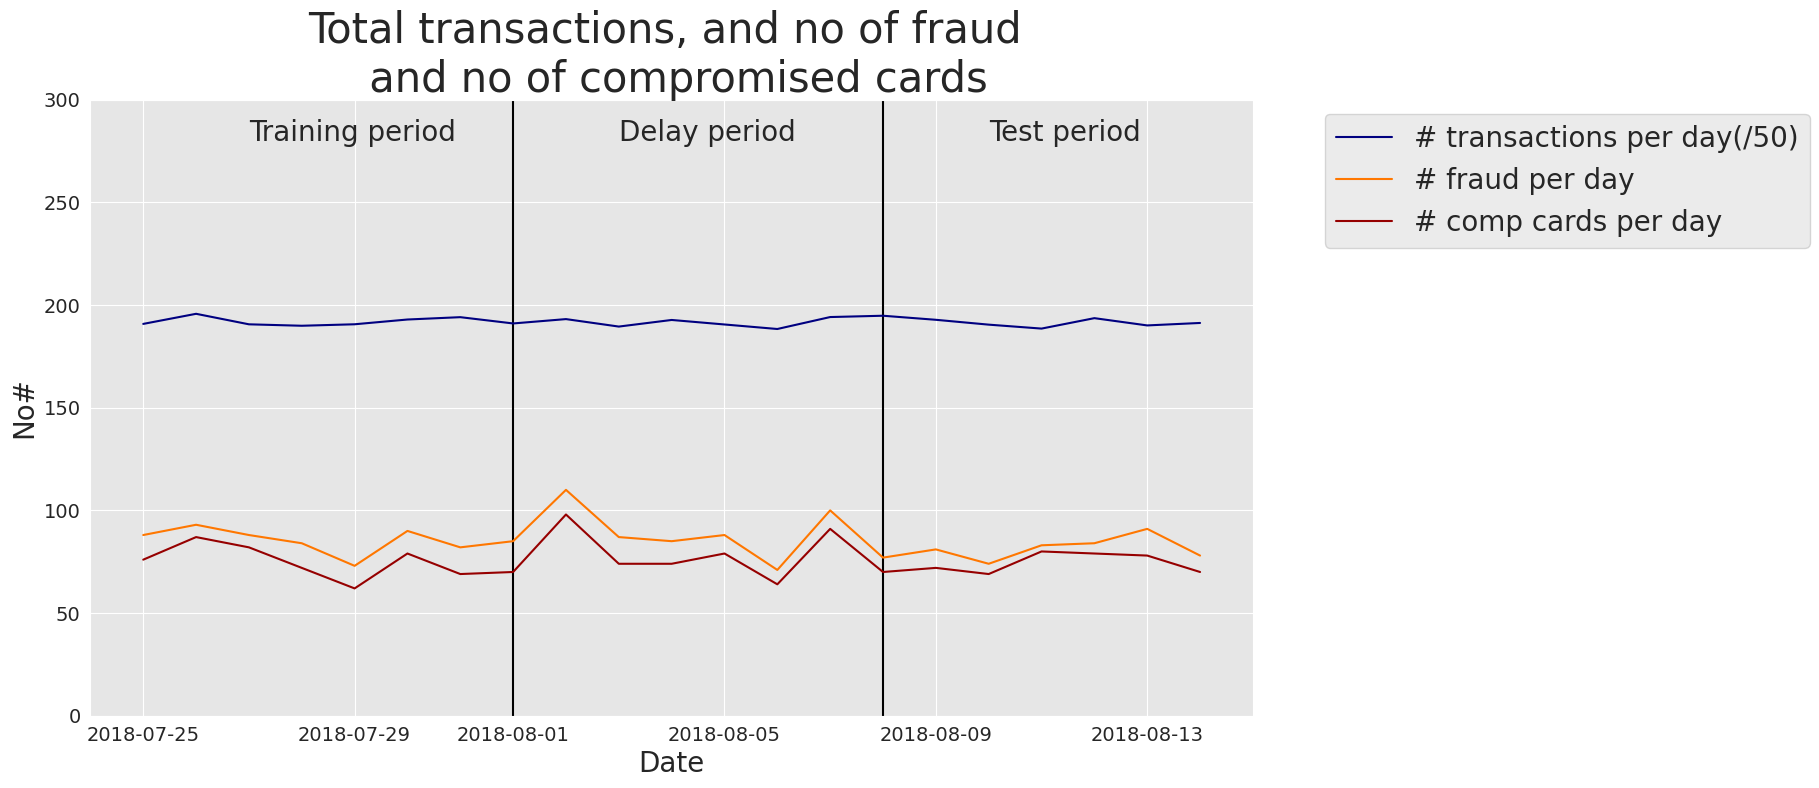

In [10]:
cmap = plt.get_cmap('jet')
colors = {'nb_tx_per_day': cmap(0),
          'nb_fraud_per_day': cmap(200),
          'nb_compromised_cards_per_day': cmap(250)
          }

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Traning period
start_date_training = datetime.datetime.strptime('2018-07-25', '%Y-%m-%d')
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training + datetime.timedelta(days=delta_train - 1)

# Test period
start_date_test = start_date_training + datetime.timedelta(days=delta_train + delta_delay)
end_date_test = start_date_training + datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=20,
                      start_date_training=start_date_training,
                      title = 'Total transactions, and no of fraud \n and no of compromised cards',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test
                      )

ax.plot(tx_stats['tx_date'], tx_stats['nb_tx_per_day']/50, 'b', color=colors['nb_tx_per_day'], label = '# transactions per day(/50)')
ax.plot(tx_stats['tx_date'], tx_stats['nb_fraud_per_day'], 'b', color=colors['nb_fraud_per_day'], label = '# fraud per day')
ax.plot(tx_stats['tx_date'], tx_stats['nb_compromised_cards_per_day'], 'b', color=colors['nb_compromised_cards_per_day'], label = '# comp cards per day')

ax.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1), fontsize=20)


In [11]:
# observation: no of transactions and fraud is similar in the training and test periods
# get the traning and test dataset

def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train = 7,
                       delta_delay = 7,
                       delta_test = 7,
                       ):

  # get the training set
  train_df = transactions_df[(transactions_df.TX_DATETIME >= start_date_training) &
                             (transactions_df.TX_DATETIME < start_date_training + datetime.timedelta(days=delta_train))]

  # get the test set data
  test_df = []

  # Note: Cards known to be compromised after the delay period are removed from the test set
  # That is, for each test day, all frauds known at (test_day - delay_period) are removed

  # First, get known defrauded customers from the training set
  known_defrauded_customers = set(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID)

  # get the relative starting day of training set
  start_tx_time_days_training = train_df.TX_TIME_DAYS.min()

  for day in range(delta_test):

    test_df_day = transactions_df[transactions_df.TX_TIME_DAYS == start_tx_time_days_training + delta_train + delta_delay + day]

    test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS == start_tx_time_days_training + delta_train + day - 1]

    new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD==1].CUSTOMER_ID)
    known_defrauded_customers = known_defrauded_customers.union(new_defrauded_customers)

    test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(known_defrauded_customers)]

    test_df.append(test_df_day)

  test_df = pd.concat(test_df)

  # Sort data sets by ascending order of transaction ID
  train_df = train_df.sort_values('TRANSACTION_ID')
  test_df = test_df.sort_values('TRANSACTION_ID')

  return (train_df, test_df)

In [12]:
train_df, test_df = get_train_test_set(transactions_df, start_date_training)

In [13]:
train_df.shape

(67240, 23)

In [14]:
train_df[train_df.TX_FRAUD==1].shape

(598, 23)

In [39]:
print(f'test_df\'s shape is {test_df.shape} and the fraud part is {test_df[test_df.TX_FRAUD==1].shape}')

test_df's shape is (58264, 23) and the fraud part is (385, 23)


In [40]:
print('the percentage of fraduluent transactions in training dataset is:\n')
print(train_df[train_df.TX_FRAUD==1].shape[0]/train_df.shape[0])

the percentage of fraduluent transactions in training dataset is:

0.008893515764425937


## Model Training: Decision Tree

In a fraud detection context, the goal is to find a function that can predict whether a transaction is fraud or not, using features that characterize the transactions

We will define the input and output features as follows:
1. The output feature will be the transaction label `TX_FRUAD`
2. The input feature will be the transaction amount `TX_AMOUNT`, as well as all the features that were computed in the previous section

In [41]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


In [45]:
# use sklearn library to fit model and get prediction
# create a func, take sklearn classifier object, training set, test set and set of input and output features.
# return a dictionary, contains the trained classifier, predictions for training set, and prediction for test set
# also the execution times for training and inference.
import time
def fit_model_and_get_predictions(classifier, train_df, test_df,
                                  input_features, output_feature='TX_FRAUD',
                                  scale=True):

  # By default, scales input data
  if scale:
    (train_df, test_df) = scaleData(train_df, test_df, input_features)

  # first fit method to train
  start_time = time.time()
  classifier.fit(train_df[input_features], train_df[output_feature])
  training_execution_time = time.time() - start_time

  # Then get the prediction as the training and test data
  start_time = time.time()
  predictions_test = classifier.predict_proba(test_df[input_features])[:,1]
  prediction_execution_time = time.time() - start_time

  predictions_train = classifier.predict_proba(train_df[input_features])[:,1]

  # The result is returned as a dictionary
  model_and_predicts_dict = {'classifier': classifier,
                              'predictions_test': predictions_test,
                              'predictions_train': predictions_train,
                              'training_execution_time': training_execution_time,
                              'prediction_execution_time': prediction_execution_time
                              }
  return model_and_predicts_dict

Now let's train a small decision tree (with maximum depth of 2). We first create a decision tree object (`sklearn.tree.DecisionTreeClassifier`), and call the func we defined above to train, and predict.

In [46]:
from sklearn.tree import DecisionTreeClassifier
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state = 0) # for reproducibility

model_and_predicts_dict = fit_model_and_get_predictions(classifier, train_df, test_df, input_features, output_feature,scale = False)

In [49]:
# get the prediction
test_df['TX_FRAUD_PREDICTED'] = model_and_predicts_dict['predictions_test']
test_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD_PREDICTED
134215,1236698,2018-08-08 00:01:14,2765,2747,42.32,11145674,129,0,0,0,...,67.468529,120.0,64.611750,2.0,0.0,9.0,0.0,31.0,0.000000,0.003536
134216,1236699,2018-08-08 00:02:33,714,2073,108.19,11145753,129,0,0,0,...,79.955455,124.0,85.365645,2.0,0.0,10.0,0.0,23.0,0.000000,0.003536
134218,1236701,2018-08-08 00:08:40,4982,1258,26.13,11146120,129,0,0,0,...,56.269167,61.0,49.095902,1.0,0.0,10.0,0.0,26.0,0.076923,0.003536
134219,1236702,2018-08-08 00:08:41,704,8501,65.81,11146121,129,0,0,0,...,62.643333,11.0,63.287273,1.0,0.0,6.0,0.0,23.0,0.000000,0.003536
134220,1236703,2018-08-08 00:10:34,3085,4208,55.22,11146234,129,0,0,0,...,71.993846,72.0,59.899306,1.0,0.0,5.0,0.0,21.0,0.523810,0.003536


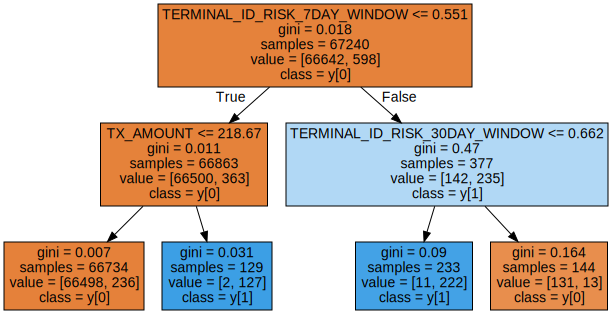

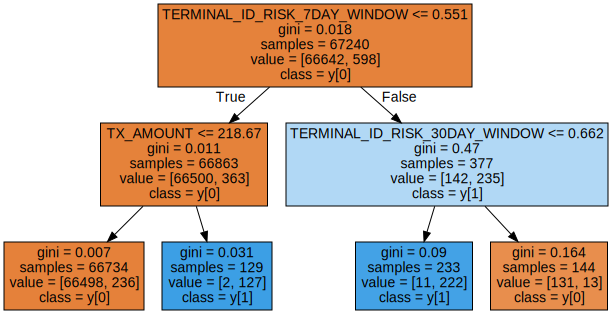

In [51]:
# Display the decisionTree
display(graphviz.Source(sklearn.tree.export_graphviz(classifier, feature_names=input_features, class_names=True, filled=True)))

## Performance assessment
We will compute three performance metrics:
AUC ROC, Average Precision(AP), and Card Precision top-k(CP@K)
1. The card precision top-k is the most pragmatic and interpretable measure. It takes into account the fact that investigators can only check a maximum of k potentially fraudulent cards per day. It's computed by ranking, for every day in the test set, the most fraudulent transactions, and selecting the k cards whose transactions have the highest fraud prob. The precision (proportion of actual compromised cards out of predicted compromised cards) is then computed for each day. The Card Precision top-k is the average of these daily precisions. The number k will be set to 100. `Precision top-k metrics`
2. The Average Precision is a proxy for the Card Precision top-k, that integrates precision for all possible k values. `Precision-Recall Curve`
3. The AUC ROC is an alternative measure to the Average precision, which gives more importantce to scores obtained with higher k values.This is the most widely used performance metric for fraud detection in the literature. `Receiving Operating Characteristic Curve`

All three metrics provide values in the interval [0, 1]. Higher values == higher performance.

In [59]:
# Define three functions to calculate the three metrics above
def card_precision_top_k_day(df_day, top_k):

  # takes the max of predictions and the max of label TX_FRAUD for each customer
  # sorts by decreasing order of fraudulent prediction
  df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by='predictions', ascending=False).reset_index(drop=False)

  # get the top k most suspicious cards
  df_day_top_k = df_day.head(top_k)
  list_detected_compromised_cards = list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)

  # Compute precision top k
  card_precision_top_k = len(list_detected_compromised_cards) / top_k

  return list_detected_compromised_cards, card_precision_top_k


def card_precision_top_k(predictions_df, top_k, remove_detected_compromised_cards=True):

  # Sort by days increasing order
  list_days = list(predictions_df['TX_TIME_DAYS'].unique())
  list_days.sort()

  # At first, the list of detected compromised cards is empty
  list_detected_compromised_cards = []

  card_precision_top_k_per_day_list = []

  nb_compromised_cards_per_day = []

  # for each day, compute precision top k
  for day in list_days:

    df_day = predictions_df[predictions_df['TX_TIME_DAYS'] == day]
    df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]

    # let's remove detected compromised cards from the set of daily transactions
    df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_compromised_cards)==False]

    nb_compromised_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))

    detected_compromised_cards, card_precision_top_k = card_precision_top_k_day(df_day, top_k)

    card_precision_top_k_per_day_list.append(card_precision_top_k)

    # let's update the list of detected compromised cards
    if remove_detected_compromised_cards:
      list_detected_compromised_cards.extend(detected_compromised_cards)

  # Compute the mean
  mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()

  # returns precision top k per day as a list , and resulting mean
  return nb_compromised_cards_per_day, card_precision_top_k_per_day_list, mean_card_precision_top_k

def performance_assessment(predictions_df, output_feature='TX_FRAUD', prediction_feature='predictions',
                           top_k_list=[100], rounded=True):

  AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
  AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])

  performances = pd.DataFrame([[AUC_ROC, AP]],
                              columns = ['AUC_ROC', 'Average precision'])

  for top_k in top_k_list:
    _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
    performances['Card precision @' + str(top_k)] = mean_card_precision_top_k

  if rounded:
    performances = performances.round(3)

  return performances


In [60]:
# Let's compute the performance
predictions_df = test_df
predictions_df['predictions'] = model_and_predicts_dict['predictions_test']

performance_assessment(predictions_df, top_k_list=[100])

,AUC_ROC,Average precision,Card precision @100
0,0.763,0.496,0.241
